<a href="https://colab.research.google.com/github/jimmYA-1995/GAN_practice/blob/master/GAN_for_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow-gpu==2.0.0

In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imshow
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential, datasets, optimizers
from tensorflow.keras.datasets import mnist, cifar10 



In [50]:
np.__version__, tf.__version__

('1.16.5', '2.0.0')

In [0]:
def get_datasets(source='mnist', data_size_ratio=1.):
  dataset = datasets.mnist if source=='mnist' else datasets.cifar10

  (x_train, y_train), (x_test, y_test) = dataset.load_data()
  train_size = int(x_train.shape[0] * data_size_ratio)
  test_size = int(x_test.shape[0] * data_size_ratio)
  
  x_train, y_train = x_train[:train_size], y_train[:train_size]
  x_test, y_test = x_test[:test_size], y_test[:test_size]
  
  

  print("Xdtype: {}, Ydtype: {}".format(x_train.dtype, y_train.dtype))
  print("Training: x={} y={}, Testing: x={} y={}".format(x_train.shape,
                                                         y_train.shape,
                                                         x_test.shape,
                                                         y_test.shape))

  return (x_train, y_train), (x_test, y_test)

In [52]:
(x_train, y_train), (x_test, y_test) = get_datasets(source='cifar10', data_size_ratio=1)

Xdtype: uint8, Ydtype: uint8
Training: x=(50000, 32, 32, 3) y=(50000, 1), Testing: x=(10000, 32, 32, 3) y=(10000, 1)


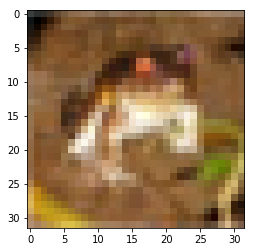

In [53]:
plt.figure()
plt.imshow(x_train[0])

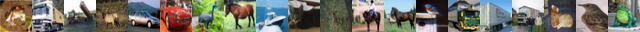

In [54]:
def showX(X):
    int_X_reshape = X.astype(np.uint8).reshape(-1,32,32,3).swapaxes(0,1).reshape(32,-1,3)
    display(Image.fromarray(int_X_reshape, mode='RGB'))

showX(x_train[:20])

## Test central crop

In [0]:
# print(x_train.shape)
# test = tf.image.central_crop(tf.convert_to_tensor(x_train), central_fraction=0.875)
# print(test.shape)
# plt.figure()
# plt.imshow(test[0])

## Build Tensorflow Dataset

In [0]:
def preprocess(x, y, crop=False):
  x = tf.cast(x, tf.float32) / 127.5 - 1 
  
  if crop:
    x = tf.image.central_crop(x, central_fraction=0.875) # 32 -> 28
#   x = tf.expand_dims(x, axis=-1)

  y = tf.one_hot(tf.squeeze(y,axis=-1), 10)
  
  return x, y

preprocessed_data = preprocess(x_train, y_train, crop=False)

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 128

ds_train = tf.data.Dataset.from_tensor_slices(preprocessed_data)
ds_train = ds_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [57]:
a_batch = next(iter(ds_train))
a_batch[0].shape, tf.math.reduce_max(a_batch[0]), tf.math.reduce_min(a_batch[0]), a_batch[1].shape

(TensorShape([128, 32, 32, 3]),
 <tf.Tensor: id=57237, shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: id=57239, shape=(), dtype=float32, numpy=-1.0>,
 TensorShape([128, 10]))

In [0]:
# ORIGINAL generator
LATENT_DIM = 100
class Generator(Model):
  def __init__(self):
    super().__init__()
    self.fc1 = layers.Dense(4*4*512, use_bias=False, input_shape=(LATENT_DIM + 10,))
    self.bn = [layers.BatchNormalization() for _ in range(4)]
    self.leaky_relu = [layers.LeakyReLU(alpha=0.2) for _ in range(4)] 
    # deConV layer
    self.convtr_0 = layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding="SAME", use_bias=False)
    self.convtr_1 = layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding="SAME", use_bias=False)
    self.convtr_2 = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="SAME", use_bias=False)
    self.convtr_3 = layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding="SAME", activation="tanh")
    
  @tf.function
  def call(self, inputs, is_training=False):
    x = layers.concatenate([inputs[0], inputs[1]])
    x = self.fc1(x)
    x = self.bn[0](x, training=is_training)
    x = self.leaky_relu[0](x)
    x = tf.reshape(x, shape=[-1,4,4,512])

    x = self.convtr_0(x) # bs, 8, 8, 128
    x = self.bn[1](x, training=is_training)   
    x = self.leaky_relu[1](x)

    x = self.convtr_1(x) # bs, 16, 16, 128
    x = self.bn[2](x, training=is_training)
    x = self.leaky_relu[2](x)

    x = self.convtr_2(x) # bs, 32, 32, 64
    x = self.bn[3](x, training=is_training)
    x = self.leaky_relu[3](x)
    
    x = self.convtr_3(x) # bs, 32, 32, 3 (RGB)
    
    return x

In [0]:
# ORIGINAL Discriminator
# class Discriminator(Model):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = layers.Conv2D(64, (5,5), strides=(2,2), padding="SAME")
#     self.drop1 = layers.Dropout(0.3)
#     self.conv2 = layers.Conv2D(128, (5,5), strides=(2,2), padding="SAME")
#     self.drop2 = layers.Dropout(0.3)
#     self.flatten = layers.Flatten()
#     self.fc1 = layers.Dense(50)
#     self.bn = layers.BatchNormalization()
#     self.fc2 = layers.Dense(1)
#   @tf.function 
#   def call(self, inputs, is_training=False):
#     x = self.conv1(inputs[0]) # bs, 14, 14, 64
#     x = tf.nn.leaky_relu(x)
#     x = self.drop1(x, training=is_training)
#     x = self.conv2(x) # bs, 7, 7, 128
#     x = tf.nn.leaky_relu(x)
#     x = self.drop2(x, training=is_training)
#     x = self.flatten(x)
#     # input(x.shape)
#     x = layers.concatenate([x, inputs[1]]) # bs, 7x7x128+10
#     x = self.fc1(x) # bs, 50
#     x = self.bn(x, training=is_training)
#     x = tf.nn.leaky_relu(x)
#     x = self.fc2(x) # bs, 1
    
#     return x

In [0]:
# # Define generator
# LATENT_DIM = 100
# class Generator(Model):
#   def __init__(self):
#     super().__init__()
#     self.fc1 = layers.Dense(8*8*128, input_shape=(LATENT_DIM + 10,))
#     self.bn = [layers.BatchNormalization(momentum=0.9) for _ in range(7)]
#     self.leaky_relu = [layers.LeakyReLU(alpha=0.1) for _ in range(7)]
    
#     self.convtr = [layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="SAME") for _ in range(2)]
#     self.conv1 = layers.Conv2D(128, (4,4), strides=(1,1), padding="SAME")
#     self.conv2 = layers.Conv2D(128, (5,5), strides=(1,1), padding="SAME")
#     self.conv3 = layers.Conv2D(128, (5,5), strides=(1,1), padding="SAME")
#     self.conv4 = layers.Conv2D(128, (5,5), strides=(1,1), padding="SAME")
#     self.conv5 = layers.Conv2D(3, (5,5), strides=(1,1), padding="SAME", activation="tanh")
    
#   @tf.function
#   def call(self, inputs, is_training=False):
#     x = layers.concatenate([inputs[0], inputs[1]]) # bs, latent_dim+10
#     x = self.fc1(x)
#     x = self.bn[0](x, training=is_training)
#     x = self.leaky_relu[0](x)
#     x = tf.reshape(x, shape=[-1,8,8,128])

#     x = self.conv1(x)
#     x = self.bn[1](x, training=is_training)
#     x = self.leaky_relu[1](x)

#     x = self.convtr[0](x) 
#     x = self.bn[2](x, training=is_training)
#     x = self.leaky_relu[2](x)

#     x = self.conv2(x)
#     x = self.bn[3](x, training=is_training)
#     x = self.leaky_relu[3](x)

#     x = self.convtr[1](x) 
#     x = self.bn[4](x, training=is_training)
#     x = self.leaky_relu[4](x)

#     x = self.conv3(x)
#     x = self.bn[5](x, training=is_training)
#     x = self.leaky_relu[5](x)

#     x = self.conv4(x)
#     x = self.bn[6](x, training=is_training)
#     x = self.leaky_relu[6](x)
    
#     x = self.conv5(x)
    
#     return x

In [0]:
# DEFINE Discriminator
class Discriminator(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = layers.Conv2D(64, (3,3), strides=(1,1), padding="SAME")
    self.conv2 = layers.Conv2D(64, (4,4), strides=(2,2), padding="SAME")
    self.conv3 = layers.Conv2D(128, (3,3), strides=(1,1), padding="SAME")
    self.conv4 = layers.Conv2D(128, (4,4), strides=(2,2), padding="SAME")
    self.conv5 = layers.Conv2D(256, (3,3), strides=(1,1), padding="SAME")
    self.conv6 = layers.Conv2D(256, (4,4), strides=(2,2), padding="SAME")
    self.conv7 = layers.Conv2D(512, (3,3), strides=(1,1), padding="SAME")

    self.bn = [layers.BatchNormalization(momentum=0.9) for _ in range(7)]
    self.leaky_relu = [layers.LeakyReLU(alpha=0.2) for _ in range(8)]

    self.flatten = layers.Flatten()
    # self.fc1 = layers.Dense(512)
    self.fc2 = layers.Dense(1, activation='sigmoid')

  @tf.function 
  def call(self, inputs, is_training=False):
    x = self.conv1(inputs[0])
    # x = self.bn[0](x, training=is_training)
    x = self.leaky_relu[0](x)

    x = self.conv2(x)
    x = self.bn[1](x, training=is_training)
    x = self.leaky_relu[1](x)

    x = self.conv3(x)
    x = self.bn[2](x, training=is_training)
    x = self.leaky_relu[2](x)

    x = self.conv4(x)
    x = self.bn[3](x, training=is_training)
    x = self.leaky_relu[3](x)

    x = self.conv5(x)
    x = self.bn[4](x, training=is_training)
    x = self.leaky_relu[4](x)

    x = self.conv6(x)
    x = self.bn[5](x, training=is_training)
    x = self.leaky_relu[5](x)

    x = self.conv7(x)
    x = self.bn[6](x, training=is_training)
    x = self.leaky_relu[6](x)

    x = self.flatten(x)
    x = layers.concatenate([x, inputs[1]])
    # x = self.fc1(x) # bs, 512
    x = self.leaky_relu[7](x)
    x = self.fc2(x) # bs, 1
    
    return x

In [0]:
generator = Generator()
discriminator = Discriminator()
generator.build(input_shape=[(None,LATENT_DIM),(None,10)])
discriminator.build(input_shape=[(None,32,32,3),(None,10)])

In [0]:
  # Define both loss function
def generator_loss(generated_output):
  return tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(generated_output), generated_output))

In [0]:
def discriminator_loss(real_output, generated_output, flip_label=True, soft_label=True):
  if soft_label:
    real_label = tf.random.uniform(real_output.shape, 0.8, 1.0)
    gen_label = tf.random.uniform(generated_output.shape, 0., 0.2)
  
  if flip_label:
    a = tf.random.uniform(real_label.shape, 0.0, 1.0)
    indices = tf.where(a < 0.05)
    updates = 1 - tf.gather_nd(real_label, indices)
    real_label = tf.tensor_scatter_nd_update(real_label, indices, updates)

    b = tf.random.uniform(real_label.shape, 0.0, 1.0)
    indices = tf.where(a < 0.05)
    updates = 1 - tf.gather_nd(gen_label, indices)
    gen_label = tf.tensor_scatter_nd_update(gen_label, indices, updates)

  real_loss = tf.reduce_mean(tf.losses.binary_crossentropy(real_label, real_output))
  generated_loss = tf.reduce_mean(tf.losses.binary_crossentropy(gen_label, generated_output))

#   total_loss = real_loss + generated_loss

  return real_loss, generated_loss

In [0]:
generator_optimizer = optimizers.Adam(lr=2e-4, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(3e-4)

In [0]:
EPOCHS = 50
num_examples_to_generate = 20

# reuse this vector
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 LATENT_DIM])
condition_vector_generation = tf.one_hot(list(range(10))+list(range(10)), 10)

metrics = {}
metrics['train_Gloss'] = tf.keras.metrics.Mean('generator_loss', dtype=tf.float32)
metrics['train_Dloss_real'] = tf.keras.metrics.Mean('discriminator_loss_real', dtype=tf.float32)
metrics['train_Dloss_gen'] = tf.keras.metrics.Mean('discriminator_loss_gen', dtype=tf.float32)

In [0]:
@tf.function
def train_step(images, labels, print_loss=False):
  noise = tf.random.normal([labels.shape[0], LATENT_DIM]) # handle remainder
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_real, tf.GradientTape() as disc_tape_gen :
    generated_images = generator([noise, labels], is_training=True)

    real_output = discriminator([images, labels], is_training=True)
    generated_output = discriminator([generated_images, labels], is_training=True)

    gen_loss = generator_loss(generated_output)
    disc_loss_real, disc_loss_gen = discriminator_loss(real_output, generated_output)
    if print_loss:
      print("[Sample LOSS] gen:{} disc_real:{} disc_gen:{}".format(gen_loss, disc_loss_real, disc_loss_gen))

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator_real = disc_tape_real.gradient(disc_loss_real, discriminator.trainable_variables)
  gradients_of_discriminator_gen = disc_tape_gen.gradient(disc_loss_gen, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator_real, discriminator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator_gen, discriminator.trainable_variables))
    
  metrics['train_Gloss'](gen_loss)
  metrics['train_Dloss_real'](disc_loss_real)
  metrics['train_Dloss_gen'](disc_loss_gen)

In [0]:
def plot_numBar(images):
  images = np.uint8(images*127.5+128).clip(0, 255)
  concat_image = np.transpose(images, [1,0,2,3]).reshape((32,-1,3))
  display(Image.fromarray(concat_image))

[Sample LOSS] gen:Tensor("Mean_1:0", shape=(), dtype=float32) disc_real:Tensor("Mean_3:0", shape=(), dtype=float32) disc_gen:Tensor("Mean_5:0", shape=(), dtype=float32)
[Sample LOSS] gen:Tensor("Mean_1:0", shape=(), dtype=float32) disc_real:Tensor("Mean_3:0", shape=(), dtype=float32) disc_gen:Tensor("Mean_5:0", shape=(), dtype=float32)
Epoch(171.71 sec): 0, gen_loss: 2.5329456329345703, disc_loss_for_real: 0.5180944204330444, disc_loss_for_gen: 0.6682118773460388


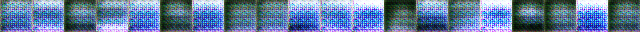

Epoch(145.74 sec): 1, gen_loss: 1.3223347663879395, disc_loss_for_real: 0.6170517206192017, disc_loss_for_gen: 0.625288724899292


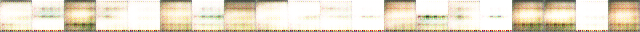

Epoch(145.68 sec): 2, gen_loss: 1.2080011367797852, disc_loss_for_real: 0.6205614805221558, disc_loss_for_gen: 0.6370943784713745


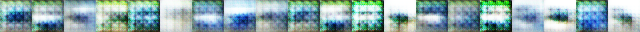

Epoch(145.79 sec): 3, gen_loss: 1.3638607263565063, disc_loss_for_real: 0.5989890098571777, disc_loss_for_gen: 0.5994822978973389


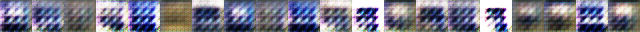

Epoch(145.74 sec): 4, gen_loss: 1.4738937616348267, disc_loss_for_real: 0.5854629874229431, disc_loss_for_gen: 0.6068447828292847


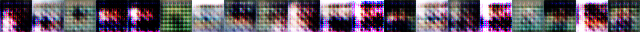

Epoch(145.65 sec): 5, gen_loss: 1.7166037559509277, disc_loss_for_real: 0.5252733826637268, disc_loss_for_gen: 0.5419213771820068


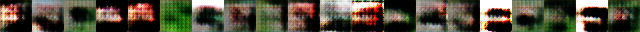

Epoch(145.72 sec): 6, gen_loss: 1.5888381004333496, disc_loss_for_real: 0.5302214026451111, disc_loss_for_gen: 0.5442844033241272


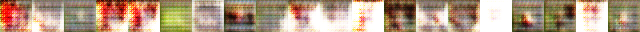

Epoch(145.63 sec): 7, gen_loss: 1.9858498573303223, disc_loss_for_real: 0.418672651052475, disc_loss_for_gen: 0.4272339642047882


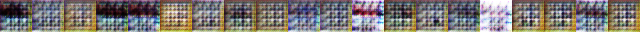

Epoch(145.72 sec): 8, gen_loss: 1.9867613315582275, disc_loss_for_real: 0.4102901518344879, disc_loss_for_gen: 0.4134695529937744


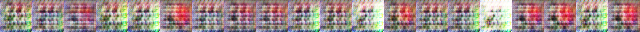

Epoch(145.74 sec): 9, gen_loss: 1.9783984422683716, disc_loss_for_real: 0.4088621139526367, disc_loss_for_gen: 0.41059646010398865


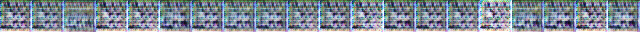

Epoch(145.65 sec): 10, gen_loss: 1.9875160455703735, disc_loss_for_real: 0.40845373272895813, disc_loss_for_gen: 0.4088698923587799


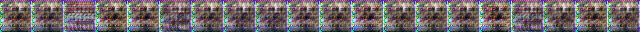

Epoch(145.71 sec): 11, gen_loss: 1.985363245010376, disc_loss_for_real: 0.40876320004463196, disc_loss_for_gen: 0.40984752774238586


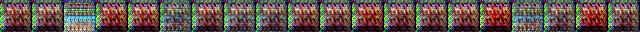

Epoch(145.62 sec): 12, gen_loss: 1.9982572793960571, disc_loss_for_real: 0.4069872200489044, disc_loss_for_gen: 0.4107995331287384


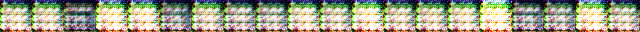

Epoch(145.71 sec): 13, gen_loss: 1.991201400756836, disc_loss_for_real: 0.4065284729003906, disc_loss_for_gen: 0.4084322154521942


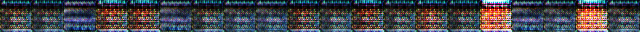

Epoch(145.81 sec): 14, gen_loss: 1.9743081331253052, disc_loss_for_real: 0.40976041555404663, disc_loss_for_gen: 0.4090498089790344


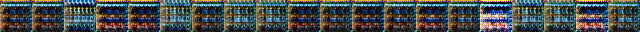

Epoch(145.63 sec): 15, gen_loss: 1.8249205350875854, disc_loss_for_real: 0.4563111662864685, disc_loss_for_gen: 0.473156601190567


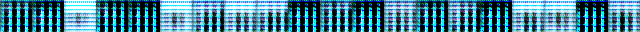

Epoch(145.66 sec): 16, gen_loss: 1.030242681503296, disc_loss_for_real: 0.6446942687034607, disc_loss_for_gen: 0.6453201174736023


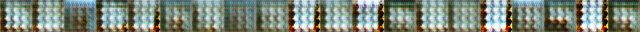

Epoch(145.65 sec): 17, gen_loss: 0.8287203907966614, disc_loss_for_real: 0.6814457178115845, disc_loss_for_gen: 0.6658343076705933


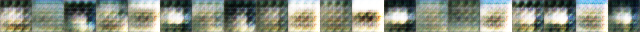

Epoch(145.56 sec): 18, gen_loss: 1.0240509510040283, disc_loss_for_real: 0.6162880659103394, disc_loss_for_gen: 0.6365997791290283


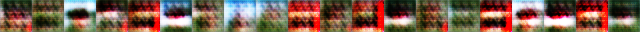

Epoch(145.70 sec): 19, gen_loss: 1.118299126625061, disc_loss_for_real: 0.6105479598045349, disc_loss_for_gen: 0.6200200319290161


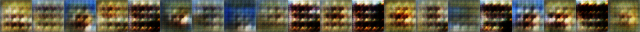

Epoch(145.73 sec): 20, gen_loss: 0.8655233383178711, disc_loss_for_real: 0.6713758111000061, disc_loss_for_gen: 0.6542369723320007


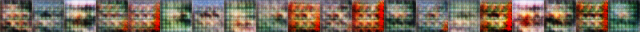

Epoch(145.62 sec): 21, gen_loss: 0.7938237190246582, disc_loss_for_real: 0.6728562712669373, disc_loss_for_gen: 0.6626282334327698


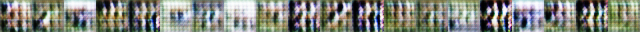

Epoch(145.44 sec): 22, gen_loss: 0.7941341996192932, disc_loss_for_real: 0.6775567531585693, disc_loss_for_gen: 0.6662368774414062


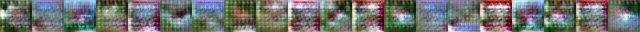

Epoch(145.38 sec): 23, gen_loss: 0.7953526377677917, disc_loss_for_real: 0.6831158399581909, disc_loss_for_gen: 0.6685422658920288


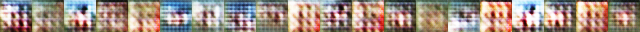

In [0]:
PATH = 'cifar10/exp1'
train_log_dir = 'logs/{}/'.format(PATH)
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

for epoch in range(EPOCHS):
  start_time = time.time()

  for i, (images, labels ) in enumerate(ds_train):
    print_loss=True if i == 0 else False
    train_step(images, labels, print_loss=print_loss)
  
  with train_summary_writer.as_default():
     tf.summary.scalar('GLoss', metrics['train_Gloss'].result(), step=epoch)
     tf.summary.scalar('DLoss_real', metrics['train_Dloss_real'].result(), step=epoch)
     tf.summary.scalar('DLoss_gen', metrics['train_Dloss_gen'].result(), step=epoch)

  template = 'Epoch({:.2f} sec): {}, gen_loss: {}, disc_loss_for_real: {}, disc_loss_for_gen: {}'      
  print(template.format(time.time()-start_time, epoch, metrics['train_Gloss'].result(), metrics['train_Dloss_real'].result(), metrics['train_Dloss_gen'].result()))
  fake = generator([random_vector_for_generation, condition_vector_generation], is_training=False)
  plot_numBar(fake)
    
  metrics['train_Gloss'].reset_states()
  metrics['train_Dloss_real'].reset_states()
  metrics['train_Dloss_gen'].reset_states()

In [0]:
# MODEL_PATH = 'models/cifar10_GAN/alldata'
# generator.save_weights(MODEL_PATH, save_format='tf')

In [0]:
# # load & use model
# new_model = Generator()
# new_model.build(input_shape=[(None,LATENT_DIM),(None,10)])
# noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
# image, label = next(iter(ds_train))

# # before load weights
# bad_images = new_model([noise, label], is_training=True)
# plot_numBar(bad_images)

In [0]:
# new_model.load_weights(MODEL_PATH)

# my_label = list([3,3,2,2,8,8,9,9,0,0])
# noise = tf.random.normal([len(my_label), LATENT_DIM])
# my_label = tf.one_hot(my_label, 10)

# better = new_model([noise, my_label])

# plot_numBar(better)